Classification of Weather Data using a K-nearest Neighbor Model

Introduction: The department of atmospheric science here at UBC has a multitude of weather sensors deployed on the rooftop of the ESB building. This data is used by phd students for their research, by professors for teaching purposes, and is inputted into numerical weather prediction models in order to make forecasts about future weather conditions. In this project we ask: are we able to predict which month a subset of data belongs to by using the variables in the dataset?  

In order to answer this question, certain meteorological concepts are necessary to understand. The first of which is that during the winter, we expect the jet stream (a jet of faster than normal wind-speed) to encircle the globe between 50 to 60° latitude. The jet stream tends to meander North and South, which creates the Rossby waves. Around the troughs (wave crest closest to the equator), the wind is moving counter-clockwise around a lower-pressure area. Around the ridges (the crest of the wave closest to the poles), the wind motion is clockwise around a higher-pressure area. In the Norther Hemisphere, winds move slower around lows and faster around highs, which causes the air to diverge aloft due to mass conservation. This divergence creates a low-pressure center, which is ideal for the genesis of mid-latitude cyclones. Mid-latitude cyclones have cold fronts and warm fronts where pressure briefly decreases, then returns to normal as the front passes. This is important because by using the spread of the daily mean pressure, we can predict which month the pressure values are taken from. Additionally, we can use the solar radiation to answer our question because the amount of solar radiation reaching the ground increases gradually from winter to summer. 


In [8]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(tidymodels))

In [23]:
weather_data <- read_csv('https://drive.google.com/uc?export=download&id=1iIzpoiZPbdhKtB8QaVKdm83utzqEAqlQ')
cat('Weather data from 2021 before being wrangled:')
head(weather_data)

names(weather_data)[names(weather_data) == "Time [UTC]"] <- "time" #renaming the columns
names(weather_data)[names(weather_data) == "Atmos Pressure [mb]"] <- "pressure" 
names(weather_data)[names(weather_data) == "Solar Rad [W/m^2]"] <- "solar_rad" 

weather <- mutate(weather_data, Date = as.Date(as.character(Date), #this turns the date integer into an actual date
                                               format = "%Y%m%d")) |>
           select(Date, solar_rad, pressure) |># selecting the relevant columns 
           group_by(Date) |> 
           summarize(across(solar_rad:pressure, mean, na.rm = TRUE)) |> # This finds the mean values for each day
           mutate(month = as.numeric(strftime(Date, '%m'))) |>
           filter(month == '1'| month == '2'| month == '3'| month == '4'| month == '5') 

weather$month[weather$month == '1'] <- 'January'
weather$month[weather$month == '2'] <- 'February'
weather$month[weather$month == '3'] <- 'March'
weather$month[weather$month == '4'] <- 'April'
weather$month[weather$month == '5'] <- 'May'

cat('Weather data from 2021 after being wrangled:')
tail(weather)         

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 35040 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Time [UTC], Min Air Temp [deg C]
dbl (11): Date, Air Temp [deg C], Hourly Precip [mm/hr], Solar Rad [W/m^2], ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Weather data from 2021 before being wrangled:

Date,Time [UTC],Air Temp [deg C],Hourly Precip [mm/hr],Solar Rad [W/m^2],Atmos Pressure [mb],Wind Speed [km/hr],Wind Dir [deg],Rel Humidity [%],Gust Speed [km/hr],Wind Chill [deg C],Max Air Temp [deg C],Min Air Temp [deg C]
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
20210101,000000,6.8,0.2,11,1017.4,1.44,90.0,97,9.72,6.8,6.8,"6.70,"
20210101,001500,6.7,0.0,4,1017.4,1.44,90.0,97,11.16,6.7,6.8,"6.70,"
20210101,003000,6.6,0.0,0,1017.5,1.44,90.0,97,12.96,6.6,6.7,"6.60,"
20210101,004500,6.6,0.0,0,1017.4,1.44,67.5,97,11.16,6.6,6.6,"6.60,"
20210101,010000,6.6,0.0,0,1017.6,1.44,112.5,97,12.96,6.6,6.6,"6.60,"
20210101,011500,6.6,0.0,0,1017.6,1.44,90.0,97,11.16,6.6,6.6,"6.60,"


Weather data from 2021 after being wrangled:

Date,solar_rad,pressure,month
<date>,<dbl>,<dbl>,<chr>
2021-05-26,140.19792,1018.922,May
2021-05-27,85.60417,1010.515,May
2021-05-28,258.27083,1018.769,May
2021-05-29,325.57292,1021.966,May
2021-05-30,191.64583,1019.404,May
2021-05-31,216.44792,1020.948,May


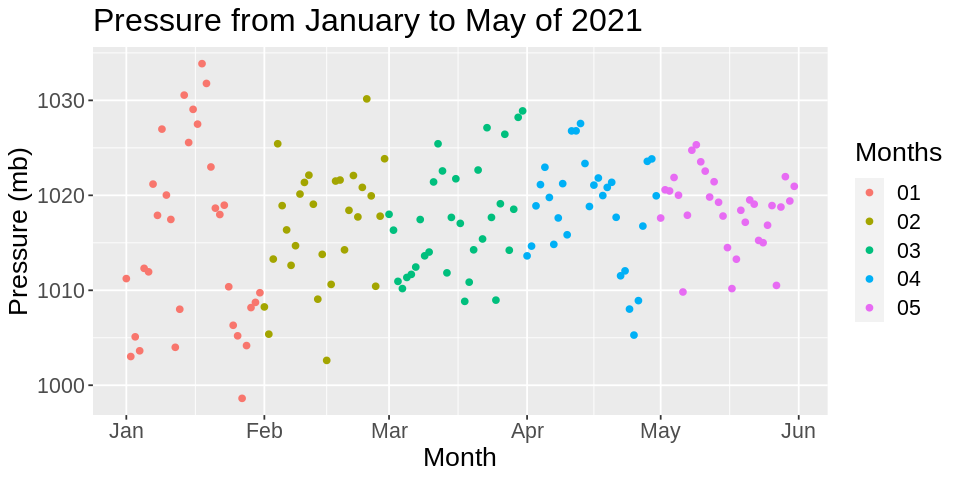

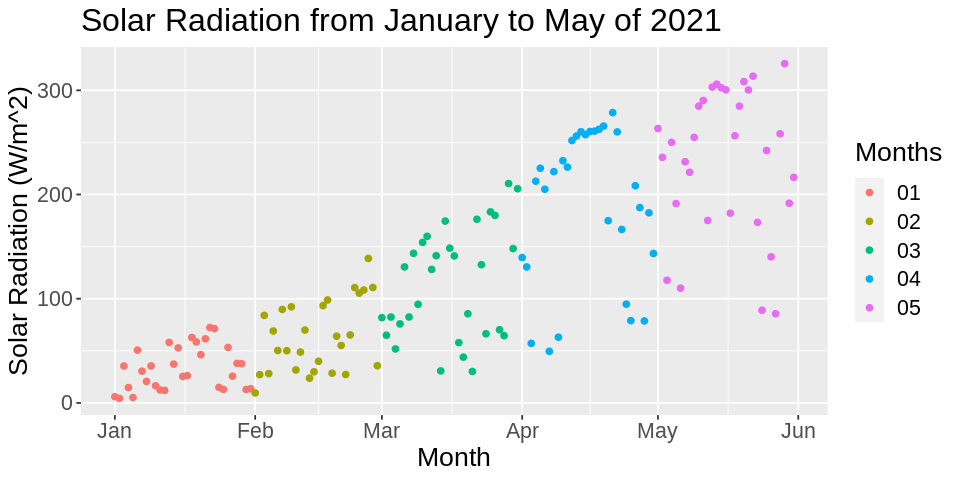

In [36]:
pressure_plot <- ggplot(weather, aes(x = Date, y = pressure, color = strftime(Date, '%m'))) +
                        geom_point() +
                        labs(x = 'Month', y = 'Pressure (mb)', title = 'Pressure from January to May of 2021', 
                             color = 'Months') +
                        theme(text = element_text(size = 16))

solar_rad_plot <- ggplot(weather, aes(x = Date, y = solar_rad, color = strftime(Date, '%m'))) +
                        geom_point() +
                        labs(x = 'Month', y = 'Solar Radiation (W/m^2)', title = 'Solar Radiation from January to May of 2021', 
                             color = 'Months')+
                        theme(text = element_text(size = 16))

pressure_plot
solar_rad_plot

What can be gathered from the two plots above is that January has the largest spread of the mean daily pressure and May has the smallest spread, just as was theorized in the introduction. The next plot shows a drastic increase in solar radiation as we approach the summer months of 2021. 

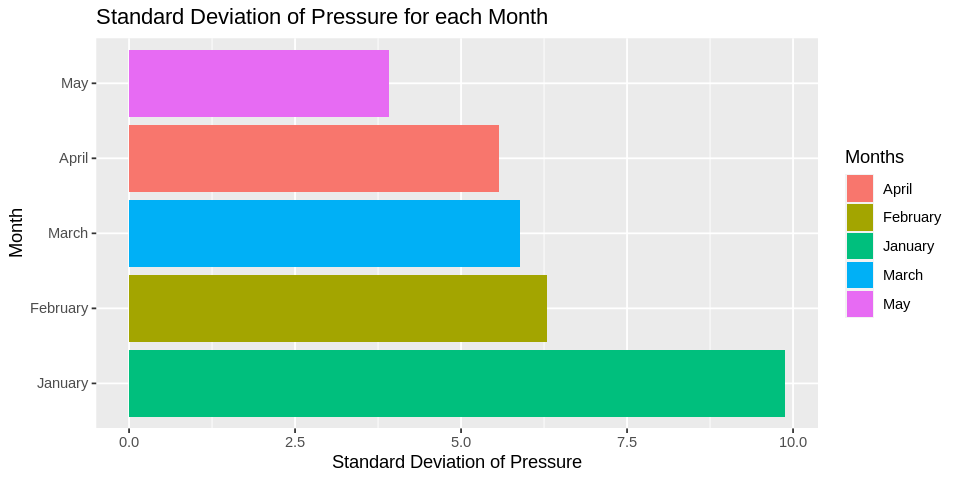

In [22]:
weather <- weather |>
           group_by(month) |>
           mutate(month = as_factor(month)) |> # month is the category
           mutate(STDev = sd(pressure)) |> # finds the standard deviation for pressure each month 
           mutate(mean_solar = mean(solar_rad))

standard_dev <- weather |>
           select(month, STDev) |> 
           distinct() # removes duplicate rows 

library(RColorBrewer)

# This plot shows how the spread of pressure values varies throughout the months
options(repr.plot.width = 8, repr.plot.height =4)
standard_dev_plot <- ggplot(standard_dev, aes(x = STDev, y = fct_reorder(month, STDev, .desc = TRUE),
                            fill = month)) +
                    geom_bar(stat = 'identity') +
                    labs(x = 'Standard Deviation of Pressure', y = 'Month', fill = 'Months', title = 'Standard Deviation of Pressure for each Month') +
                    theme(text = element_text(size = 16)) |>
                    scale_color_brewer(palette = 'Pastel1')
standard_dev_plot


The ‘Standard Deviation of Pressure' plot shows that there is in fact a decrease in the spread of daily mean pressure from January to May. As mentioned in the introduction, this is due to a higher probability of cyclogenesis in the winter months. In other words, there are more mid-latitude cyclones in the winter.  

In [5]:
# the knn model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")


# the centering and scaling recipe
# using only the mean solar radiation and the standard deveation in order to predict the month
weather_recipe <- recipe(month ~ mean_solar + STDev, data = weather) |>
    step_scale(all_predictors()) |> # scaling, so each predictors vote holds equal power over the result
    step_center(all_predictors())

knn_fit <- workflow() |>
    add_recipe(weather_recipe) |>
    add_model(knn_spec) |>
    fit(data = weather)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0
Best kernel: rectangular
Best k: 5

In [35]:
# the new observation to be classified:
# the new observations are from 2019
new_obs <- read_csv('https://drive.google.com/uc?export=download&id=1aJ5lpL415orfcdj6QnrXoXvw37boVRAR')

names(new_obs)[names(new_obs) == "Time [UTC]"] <- "time" #renaming the columns
names(new_obs)[names(new_obs) == "Atmos Pressure [mb]"] <- "pressure" 
names(new_obs)[names(new_obs) == "Solar Rad [W/m^2]"] <- "solar_rad" 

new_obs <- mutate(new_obs, Date = as.Date(as.character(Date), #this turns the date integer into an actual date
                                               format = "%Y%m%d")) |>
           select(Date, solar_rad, pressure) |># selecting the relevant columns 
           group_by(Date) |> 
           summarize(across(solar_rad:pressure, mean, na.rm = TRUE)) |> # This finds the mean values for each day
           mutate(month = as.numeric(strftime(Date, '%m'))) |>
           filter(month == '5') # any month from 1-5 can be selected for testing

new_obs$month[new_obs$month == '1'] <- 'January'
new_obs$month[new_obs$month == '2'] <- 'February'
new_obs$month[new_obs$month == '3'] <- 'March'
new_obs$month[new_obs$month == '4'] <- 'April'
new_obs$month[new_obs$month == '5'] <- 'May'

new_obs <- new_obs |>
        mutate(STDev = sd(pressure)) |>
        mutate(mean_solar = mean(solar_rad)) |>
        select(mean_solar, STDev) |>
        distinct()

cat('The new observation for the chosen month:')
new_obs

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 35040 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Time [UTC], Min Air Temp [deg C]
dbl (11): Date, Air Temp [deg C], Hourly Precip [mm/hr], Solar Rad [W/m^2], ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The new observation for the chosen month:

mean_solar,STDev
<dbl>,<dbl>
238.8434,4.477398


In [33]:
# Predicting the month
predict(knn_fit, new_obs)

.pred_class
<fct>
May


Using this model, three out of the five months were predicted successfully (January, April, May). This degree of accuracy is slightly less than predicted, but the climatological variance of the weather (year to year variance) can be very unpredictable especially with the effects of climate change. 

These finding would have an impact on researchers who come across historical data that doesn’t have a time stamp. This model could aid in figuring out the dates and months at which the data was recorded if the person making the recordings did not specify. 

Answering this question leads to the future question of how might these weather variables change from year to year instead of month to month? How would we be able to predict them in that context? 
